In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd
import scipy.stats as stats

import downscale as down

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import RegularGridInterpolator

from scipy.stats import weibull_min

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from playsound import playsound

%run ../function/functions.ipynb

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## Test beta for TRMM data in Veneto

In [2]:
# name, yy_s, yy_e = 'Coast Level', 1998, 2015
name, yy_s, yy_e = 'Low Level', 1998, 2015
# name, yy_s, yy_e = 'Medium Level', 1998, 2015
# name, yy_s, yy_e = 'High Level', 2001, 2015

maxmiss = 100

In [3]:
npix = 3 # each pixel is 10 km, with odd number the center is simetric (3, 5, 7 and 9)

thresh = 1 # default
# thresh = 2 
# thresh = 3
# thresh = 4 
# thresh = 5 
# thresh = 6 
# thresh = 7
# thresh = 8 

In [4]:
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'
# CONDITION = 'NONOVERLAP'; fig_val = 'NOVERLAP'
# CONDITION = 'FOCUS'; fig_val = 'FOCUS'
print(f'Using condition {CONDITION} for scales aggregation')

Using condition OVERLEAP for scales aggregation


## Veneto Shapefile

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Haversine distance

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0 # Earth radius in kilometers
    
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance

def find_nearest_pixel(lon2d, lat2d, lon_c, lat_c):
    # Calculate the Euclidean distance between the rain gauge and each satellite pixel
    distance = np.sqrt((lon2d - lon_c)**2 + (lat2d - lat_c)**2)
    
    # Find the index of the minimum distance (nearest pixel)
    min_idx = np.unravel_index(np.argmin(distance, axis=None), distance.shape)
    
    # Return the nearest pixel's indices and the corresponding latitude and longitude
    nearest_lat = lat2d[min_idx]
    nearest_lon = lon2d[min_idx]
    
    return min_idx, nearest_lat, nearest_lon

In [7]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','TRMM','3_hour',f'TRMM_Veneto_3h_1998_01_01_2016_12_31.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]
time_vector = DATA['time'].data

dset = np.array(DATA['PRE'])
dset[dset==np.nanmin(dset)]=0

DATA

<xarray.Dataset> Size: 93MB
Dimensions:  (time: 52592, lat: 13, lon: 17)
Coordinates:
  * time     (time) datetime64[ns] 421kB 1998-01-01 ... 2015-12-31T21:00:00
  * lat      (lat) float32 52B 43.88 44.12 44.38 44.62 ... 46.38 46.62 46.88
  * lon      (lon) float32 68B 10.12 10.38 10.62 10.88 ... 13.62 13.88 14.12
Data variables:
    PRE      (time, lat, lon) float64 93MB 0.0 0.0 0.0 0.0 ... 1.265 0.8235 0.0
Attributes:
    description:  TRMM TMPA 3 hour data for Veneto region

In [8]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Raingauge

In [9]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')

if os.path.exists(rain_dir):
    RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')
else:
    raise SystemExit(f"File not found: {rain_dir}")

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day
CL_RAIN['hh'] = pd.to_datetime(CL_RAIN['dataora']).dt.hour
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.minute

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Low Level station


,dataora,valore,qualita,yy,mm,dd,hh
488397,2014-11-09 23:00:00,0.0,1.0,2014,0,9,23
488398,2014-11-09 23:30:00,0.0,1.0,2014,30,9,23
488399,2014-11-10 00:00:00,0.0,1.0,2014,0,10,0


In [10]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Load Raingauge

In [11]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')

if os.path.exists(rain_dir):
    RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')
else:
    raise SystemExit(f"File not found: {rain_dir}")

if name == 'Coast Level':
    Id_station = '338_RO_Co.csv'
elif name == 'Low Level':
    Id_station = '274_VR_Mo.csv'
elif name == 'Medium Level':
    Id_station = '343_BL_Fo.csv'
elif name == 'High Level':
    Id_station = '348_NP_Ro.csv'
else:
    print('ERROR: Id dont found')

print(f'{name} station')
CL_INFO = RAIN[RAIN['File_Name']==Id_station]

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day
CL_RAIN['hh'] = pd.to_datetime(CL_RAIN['dataora']).dt.hour
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.minute

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN.tail(3)

Low Level station


,dataora,valore,qualita,yy,mm,dd,hh
488397,2014-11-09 23:00:00,0.0,1.0,2014,0,9,23
488398,2014-11-09 23:30:00,0.0,1.0,2014,30,9,23
488399,2014-11-10 00:00:00,0.0,1.0,2014,0,10,0


In [12]:
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN.set_index('dataora', inplace=True)

In [13]:
CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
OBS_ACUM = CL_RAIN['valore'].resample('D').sum()
OBS_1DY = pd.DataFrame({'PRE':OBS_ACUM.values, 'TIME':pd.to_datetime(OBS_ACUM.index)})

In [14]:
print(f'Station start time: {CL_RAIN.index[0]}')
print(f'Station end time  : {CL_RAIN.index[-1]}')

Station start time: 1998-01-01 00:00:00
Station end time  : 2014-11-10 00:00:00


In [15]:
print(f'Number of OBS time  : {len(OBS_1DY)}')
print(f'Number of IMERG time: {len(DATES_daily)}')

Number of OBS time  : 6158
Number of IMERG time: 6574


In [16]:
TIME_REF = pd.date_range(start=f'{yy_s}-01-01', end=f'{yy_e}-12-31', freq='d')
TIME_PD = pd.DataFrame({'TIME':TIME_REF})

In [17]:
# Fit weibull for daily OBS time
OBS_1dy_df = xr.DataArray(OBS_1DY['PRE'].values,  coords={'time':OBS_1DY['TIME'].values}, dims=('time'))
OBS_1dy_df = pd.DataFrame({'TIME':OBS_1dy_df['time'].data, 'PRCP':OBS_1dy_df.data})
OBS_1dy_df.shape

(6158, 2)

In [18]:
if len(OBS_1dy_df) < len(TIME_REF):
    print('WARNING: RAINGAUGE time is not complete. fill times with NaN')
    OBS_TMP = pd.merge(OBS_1dy_df, TIME_PD, on='TIME', how='right')
    OBS_xr = xr.DataArray(OBS_TMP['PRCP'].values,  coords={'time':OBS_TMP['TIME'].values}, dims=('time'))
elif len(OBS_1dy_df) == len(TIME_REF):
    print('GOOD: RAINGAUGE has certain times!!')
    OBS_xr = xr.DataArray(OBS_1dy_df['PRCP'].values,  coords={'time':OBS_1dy_df['TIME'].values}, dims=('time'))
else:
    print('ERROR: RAINGAUGE has too much times, verify!!')
    OBS_xr = xr.DataArray(OBS_1dy_df['PRCP'].values,  coords={'time':OBS_1dy_df['TIME'].values}, dims=('time'))
    print(f'OBS lenght : {len(OBS_1dy_df)}')
    print(f'TIME lenght: {len(TIME_REF)}')

In [19]:
OBS_NCW_1dy, OBS_YEARS = down.fit_yearly_weibull(OBS_xr, thresh=1, maxmiss=36)
OBS_N, OBS_C, OBS_W = down.wei_fit(OBS_1dy_df.PRCP.values, 1)

In [20]:
distances = haversine(lat2d, lon2d, CL_INFO['Lat'].values[0],CL_INFO['Lon'].values[0])

min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

clat = lats[min_index[0]]
clon = lons[min_index[1]]

TRMM_ML = dset[:,min_index[0],min_index[1]]

print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {CL_INFO['Lat'].values[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {CL_INFO['Lon'].values[0]}')

Nearest IMERG lat: 45.375
Station lat       : 45.42333333

Nearest IMERG lon: 11.375
Station lon       : 11.28941667


In [21]:
IMERG_pixel_3h = dset[:,min_index[0],min_index[1]] # time, lat, lon
IMERG_pixel_1dy = PRE_daily['PRE'][:,min_index[0],min_index[1]].data

In [22]:
buffer = 0.5*npix*0.25 # To define the limitis of box_3h

L1 = 25
L0 = 0.0001

dt = 3 # time scale of the precipitation product [HOURS] (default 3 hours)

origin_x = 25 # linear spatial scale of origin gridded prcp [km] (default 25)
origin_t = 24 # time scale of origin gridded pecip [HOURS] (default 24 hours)

target_x = 0.0001 # subgrid spatial scale we want pwet at [km](default 0.0001 km)
target_t = 24 # target time scale, in [HOURS] (default 24 hours)

ninterp = 2000 # number of interpolation in time dimension

# cube1size = 5 # lateral size of cube used to decide among how many single pixel average at smallest scale
tmax = 48 # maximum time scale of integration [HOURS]

acf='mar'

In [23]:
# Original data 3h time resolution
test = np.swapaxes(dset, 0, 2)
xrs0 = xr.DataArray(test,  coords={'lon':lons, 'lat':lats, 'time':DATES.data}, dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [24]:
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [25]:
# Box 3h time resolution
box_3h = xrs.where(bcond, drop = True).load()

box_lon2d, box_lat2d = np.meshgrid(box_3h['lon'].data, box_3h['lat'].data)
nlon = len(box_3h['lon'].data)
nlat = len(box_3h['lat'].data)

if nlon != nlat:
    print('downscale warning: box sizes are not equal')
if nlon % 2 == 0:
    print('downscale warning: at least one box size has even length')
if (bool(clat) and bool(clon) and clat in lats and clon in lons):
    clat = lats[np.argmin(np.abs(clat - lats))]
    clon = lons[np.argmin(np.abs(clon - lons))]
else:
    clat = lats[np.argmin(np.abs(np.mean(lats) - lats))]
    clon = lons[np.argmin(np.abs(np.mean(lons) - lons))]

box_3h.shape

(3, 3, 52592)

In [26]:
# daily time resolution
xdaily0 = box_3h.resample(time ='{}h'.format(24)).sum(dim='time', skipna=False)
xdaily = xdaily0.dropna(dim='time', how='any')

In [27]:
tsc = xdaily.loc[dict(lat = clat, lon = clon)]

# # c_excesses = np.maximum(tsc.values-thresh, 0.0)
# c_excesses = tsc.values[tsc.values > thresh]
# # c_excesses = tsc.values[tsc.values > thresh] - thresh
# # c_excesses = tsc.values

# daily time resolution weibull fit
NCW = down.wei_fit(tsc, 1)
Ns = NCW[0]
Cs = NCW[1]
Ws = NCW[2]

print(f'Daily Weibull Parameters: {Ns, Cs, Ws}')

Weibull Parameters: (101, 4.827632720489499, 1.3416349953523257)


Export as: ../fig/Veneto_IMERG_mean.png


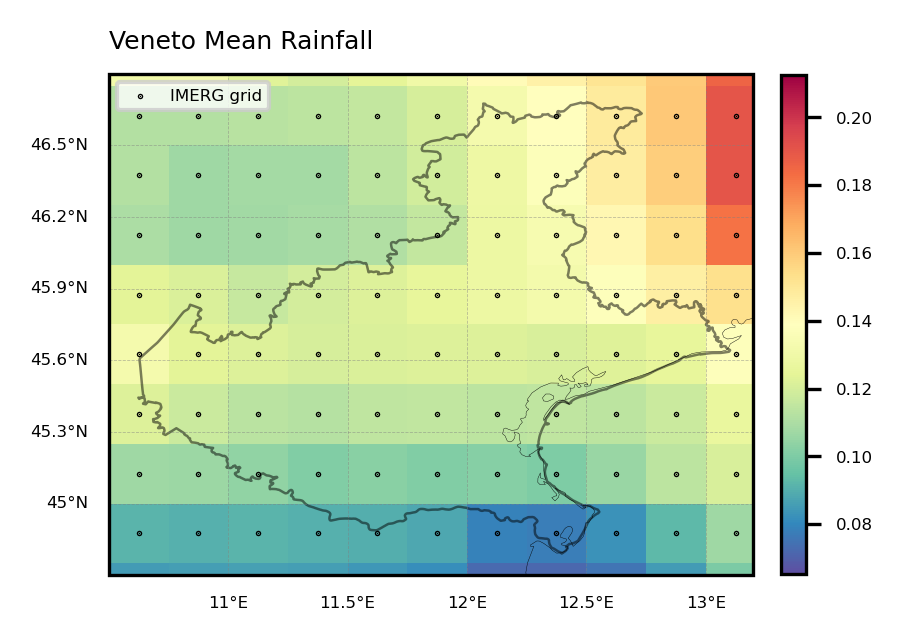

In [28]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(dset,axis=0),cmap=cmap)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='IMERG grid')

# ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=2, c='r', zorder=10, label='Station')
# ax1.scatter(clon, clat, s=2, c='k', zorder=10, label='Nearest Neighbour')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, pad=0.04, fraction=0.0358)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('Veneto Mean Rainfall', loc='left', fontsize=6)

image_dir = f'../fig/Veneto_IMERG_mean.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = True,bbox_inches ='tight',pad_inches = 0)

Export as: ../fig/Veneto_IMERG_Low_Level_1998_2015_scale.png


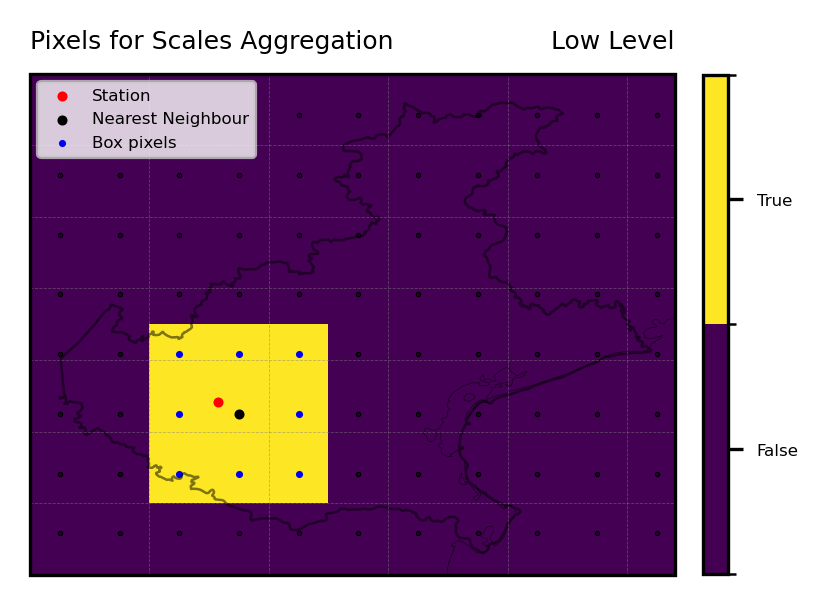

In [29]:
cmap_bin = plt.get_cmap('viridis', 3)  # Use any colormap you like with 2 discrete levels
norm = mcolors.BoundaryNorm([0, 0.5, 1], cmap_bin.N)  

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)
# a1 = ax1.pcolormesh(lon2d, lat2d, bcond)
a1 = ax1.pcolormesh(lon2d, lat2d, bcond, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o')
ax1.scatter(CL_INFO['Lon'], CL_INFO['Lat'], s=2, c='r', zorder=10, label='Station')
ax1.scatter(clon, clat, s=2, c='k', zorder=10, label='Nearest Neighbour')
ax1.scatter(box_lon2d, box_lat2d, s=0.5, c='b', label='Box pixels')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, pad=0.04, fraction=0.0358, ticks=[0, 1])
cbar.set_ticks([0.25, 0.75])  
cbar.set_ticklabels(['False', 'True'])
cbar.ax.tick_params(labelsize=4)

ax1.set_title('Pixels for Scales Aggregation', loc='left', fontsize=6)
ax1.set_title(f'{name}',loc='right',fontsize=6)

# ================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.12)

image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_scale.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = True,bbox_inches ='tight',pad_inches = 0)

## Verify the Time Scale Aggregations

In [30]:
smax = box_3h.shape[0] # max spatial scale
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*dt
tscales = tscales[tscales < tmax + 0.001]
xscales = np.arange(1, smax+1)
xscales_km = xscales*L1
ntscales = np.size(tscales)
nsscales = np.size(xscales)
pwets = np.zeros((ntscales, nsscales))

print(f'Maximum Spatial Scale: {smax*L1} km')
print(f'Number of Spatial Scale: {nsscales}')
print()
print(f'Maximum time Scale   : {tmax} h')
print(f'Number of Time Scale: {ntscales}')

Maximum Spatial Scale: 75 km
Number of Spatial Scale: 3

Maximum time Scale   : 48 h
Number of Time Scale: 10


## Verify the Time-Spatial Scale Aggregations

In [31]:
rainfall_ref = []
Swet_final = []
Swet_scale = []
print(f'Using condition {CONDITION}')
print()
for st in tscales:
    datamat = box_3h.resample(time='{}h'.format(st)).sum(dim='time', skipna = False)

    input_data = datamat.copy()

    print(f'Agregation for time scale: {st} hours')
    for ix, sx in enumerate(xscales):
        if sx == 1:
            print(f'Mean wet fraction for scale: {L1} km')
            rain_tmp = np.zeros([nlon, nlat, input_data.shape[2]])
            wet_tmp = np.zeros([nlon, nlat])
            for i in range(nlon):
                for j in range(nlat):
                    wet_tmp[i,j] = wetfrac(input_data[i,j,:].data, thresh)
                    rain_tmp[i,j] = input_data[i,j,:].data
            # print(wet_tmp.mean())
            rainfall_ref.append(np.nanmean(rain_tmp,axis=(0,1)))
            Swet_final.append(np.nanmean(wet_tmp))
            Swet_scale.append(L1)

        elif sx == smax:
            print(f'Mean wet fraction for scale: {L1*smax} km')
            rainfall_tmp = np.nanmean(input_data.data, axis=(0,1))
            wet_tmp = wetfrac(rainfall_tmp, thresh)
            # print(wet_tmp)
            rainfall_ref.append(rainfall_tmp.data)
            Swet_final.append(wet_tmp)
            Swet_scale.append(L1*smax)
        
        elif sx > 1 and sx < smax:
            print(f'Mean wet fraction for scale: {L1*sx} km')
            Swet_fraction = []

            if CONDITION == 'OVERLEAP' or CONDITION == 'NONOVERLAP':
                for i in range(nlon):
                    for j in range(nlat):

                        if CONDITION == 'OVERLEAP':
                            # WITH OVERLAP
                            box_tmp = input_data[i:i+sx,j:j+sx,:]
                        elif CONDITION == 'NONOVERLAP':
                            # WITHOUT OVERLAP
                            box_tmp = input_data[sx*i:sx*i+sx,sx*j:sx*j+sx,:]

                        if box_tmp.shape[0] == sx and box_tmp.shape[1] == sx:
                            wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
                            Swet_fraction.append(wet_tmp)

            elif CONDITION == 'FOCUS': # FOR AGREGATION WITH FOCUS IN SPECIFIC POINT (NOW ONLY WORK FOR npix = 5)
                L = sx - 1
                if sx == 2 or sx == 3:
                    origin_x_pos, origin_y_pos = 2, 2
                    for loop in range(4):
                        if loop == 0:
                            box_tmp = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos-1*L:origin_y_pos+1]
                        elif loop == 1:
                            box_tmp = input_data[origin_x_pos:origin_x+2*L,origin_y_pos-1*L:origin_y_pos+1]
                        elif loop == 2:
                            box_tmp = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos:origin_y_pos+2*L]
                        elif loop == 3:
                            box_tmp = input_data[origin_x_pos:origin_x_pos+2*L,origin_y_pos:origin_y_pos+2*L]
                        wet_tmp = wetfrac(np.nanmean(box_tmp.data,axis=(0,1)), thresh)
                        Swet_fraction.append(wet_tmp)
                
                elif sx == 4:
                    for loop in range(4):
                        if loop == 0:
                            origin_x_pos, origin_y_pos = 3, 3
                            box_tmp = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos-1*L:origin_y_pos+1]
                        elif loop == 1:
                            origin_x_pos, origin_y_pos = 1, 3
                            tmp_pos_RB = input_data[origin_x_pos:origin_x_pos+2*L,origin_y_pos-1*L:origin_y_pos+1]  
                        elif loop == 2:
                            origin_x_pos, origin_y_pos = 3, 1
                            tmp_pos_LT = input_data[origin_x_pos-1*L:origin_x_pos+1,origin_y_pos:origin_y_pos+2*L]
                        elif loop == 3:
                            origin_x_pos, origin_y_pos = 1, 1
                            tmp_pos_RT = input_data[origin_x_pos:origin_x_pos+2*L,origin_y_pos:origin_y_pos+2*L]
                        wet_tmp = wetfrac(box_tmp.nanmean(axis=(0,1)).data, thresh)
                        Swet_fraction.append(wet_tmp)

            rainfall_ref.append(np.nansum(box_tmp.data,axis=(0,1))) # Rainfall series
            Swet_final.append(np.nanmean(Swet_fraction)) # wet fraction
            Swet_scale.append(L1*sx) # Spatial scales
    print()

WET_MATRIX = np.reshape(Swet_final,(10,npix))

Using condition OVERLEAP

Agregation for time scale: 3 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 6 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 9 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 12 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 15 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 18 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction for scale: 75 km

Agregation for time scale: 24 hours
Mean wet fraction for scale: 25 km
Mean wet fraction for scale: 50 km
Mean wet fraction f

Export as: ../fig/Veneto_TRMM_Low_Level_1998_2015_agregation.png


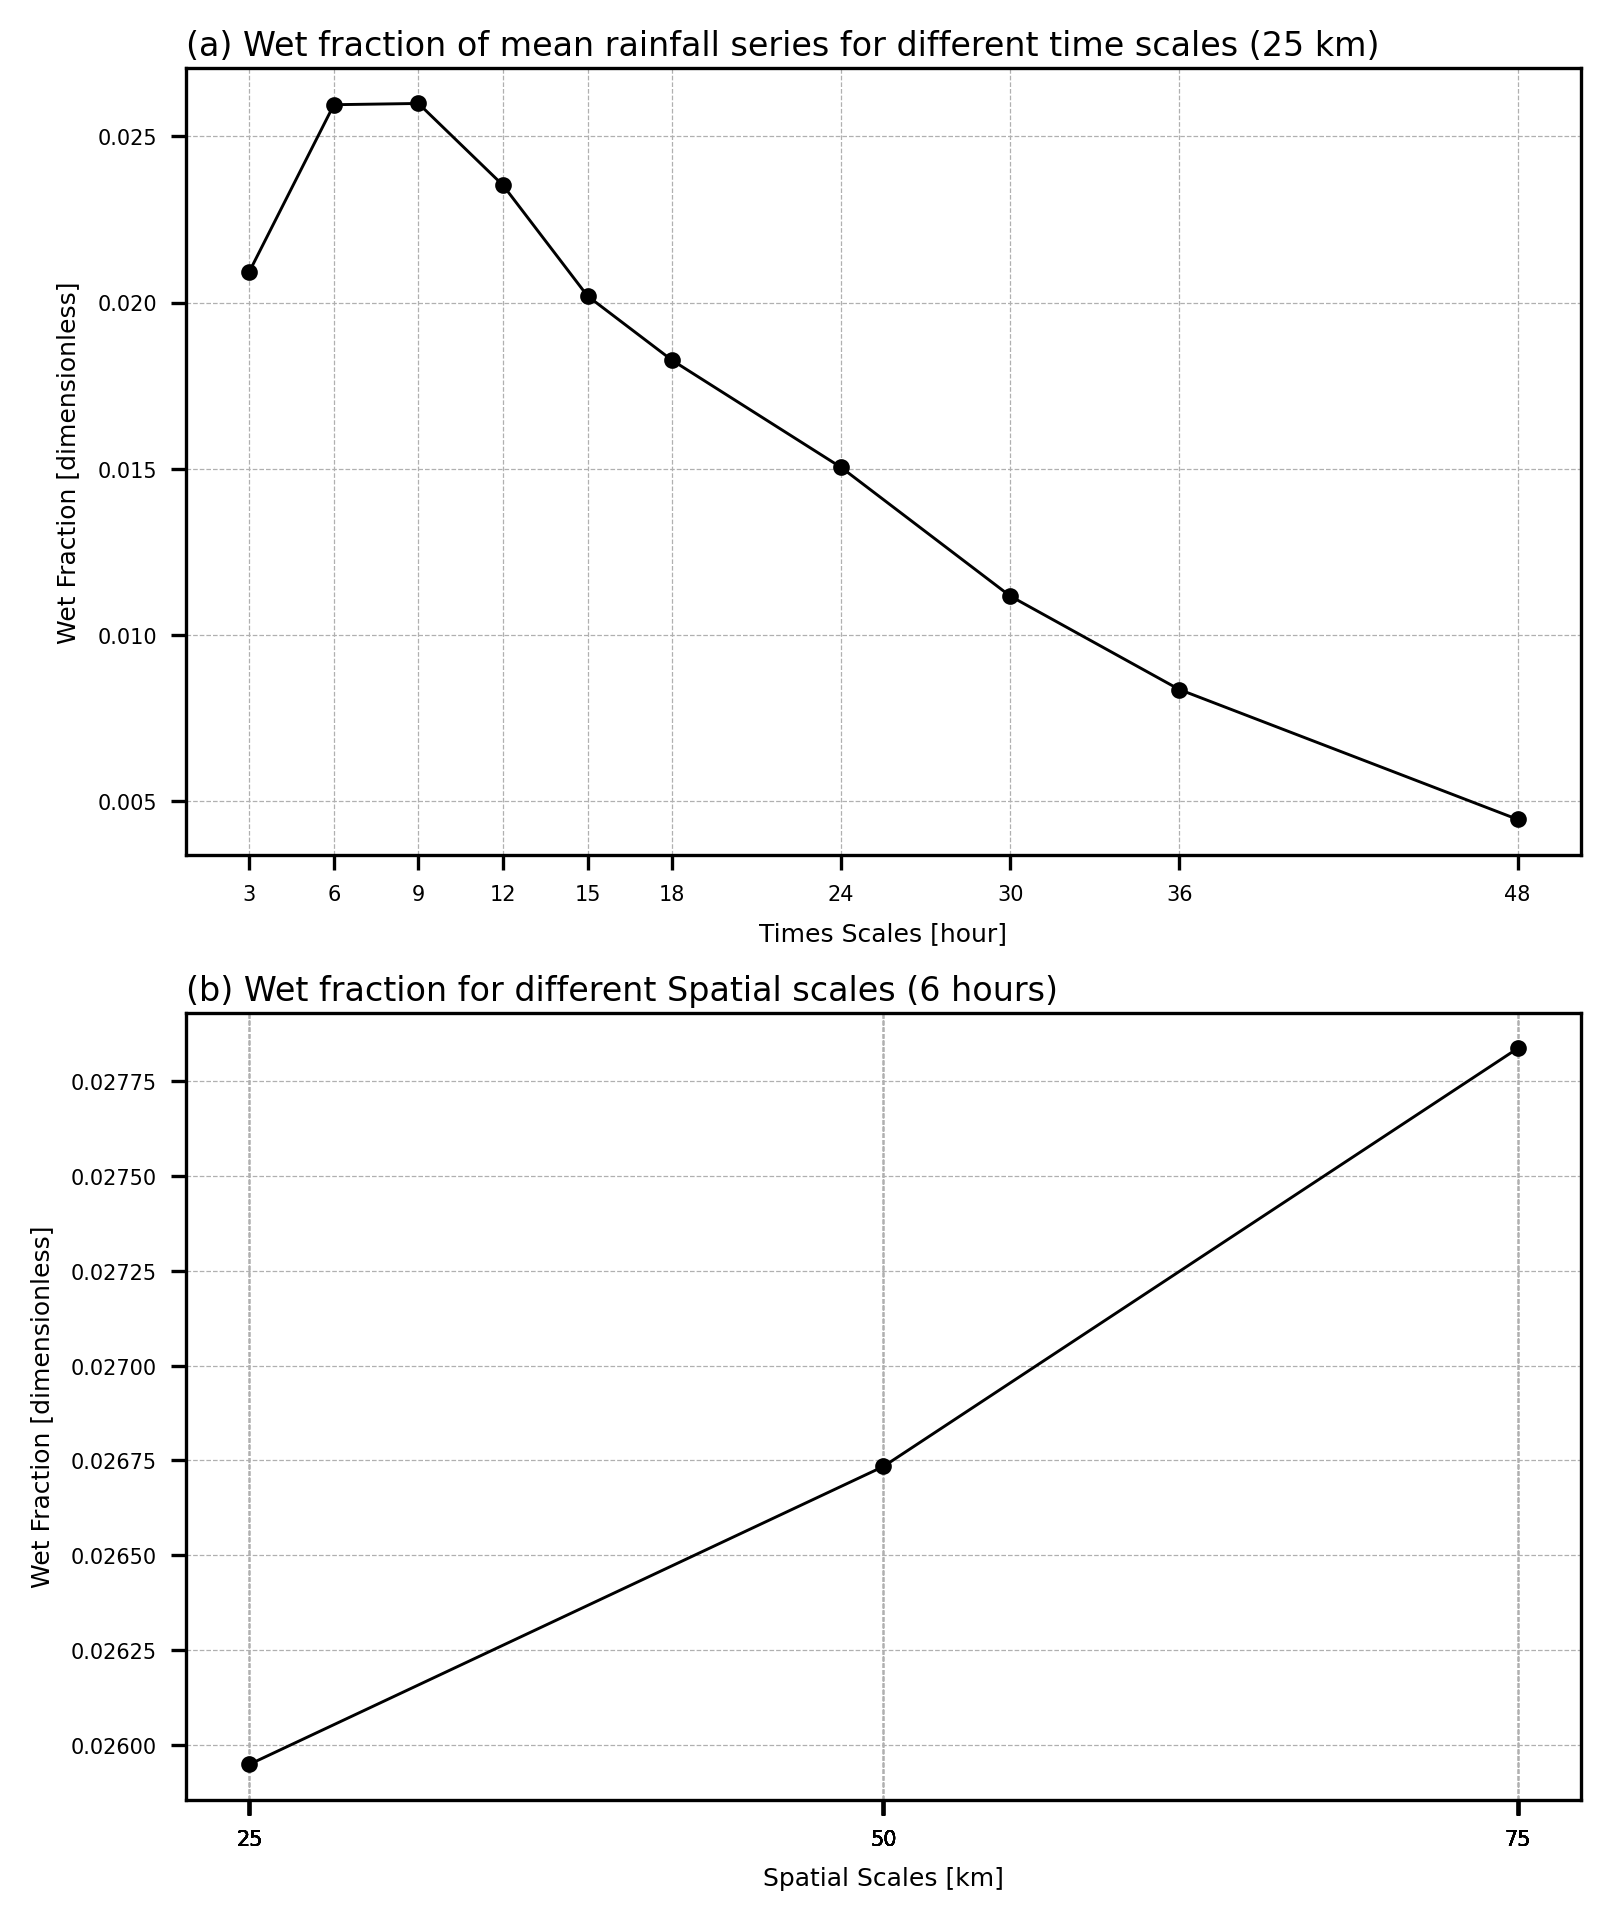

In [32]:
fig = plt.figure(figsize=(6,7.5),dpi=300)
gs = gridspec.GridSpec(2,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(tscales, WET_MATRIX[:,0], linewidth=0.7, c='k')
ax1.plot(tscales, WET_MATRIX[:,0], '.', c='k')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Times Scales [hour]', fontsize=6)
ax1.set_ylabel('Wet Fraction [dimensionless]', fontsize=6)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

ax1.set_xticks(tscales)

ax1.set_title(f'(a) Wet fraction of mean rainfall series for different time scales (25 km)', loc='left', fontsize=8, pad=3)

# ============================================================================================================================
pos_ref = 1
ax1 = plt.subplot(gs[1, 0])
ax1.plot(xscales_km, WET_MATRIX[pos_ref,:], linewidth=0.7, c='k')
ax1.plot(xscales_km, WET_MATRIX[pos_ref,:], '.', c='k')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('Spatial Scales [km]', fontsize=6)
ax1.set_ylabel('Wet Fraction [dimensionless]', fontsize=6)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

ax1.set_xticks(Swet_scale)

ax1.set_title(f'(b) Wet fraction for different Spatial scales ({tscales[pos_ref]} hours)', loc='left', fontsize=8, pad=3)

# ================================================================================================
fig.patch.set_alpha(0)

# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.12)

image_dir = f'../fig/Veneto_TRMM_{name.replace(' ','_')}_{yy_s}_{yy_e}_agregation.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir, transparent=False, bbox_inches='tight', pad_inches=0)

In [33]:
xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)

ntscales = np.size(tscales)
nxscales = np.size(xscales)

tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), ninterp) # 2000 valores entre min y max de time scale
WET_MATRIX_INTER = np.zeros((ninterp, nxscales)) # 2000, 5

for col in range(nxscales):
    WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col]) # Interpolated wet fraction matrix

In [34]:
# found the wet fraction for the pixel
print(f'Spatial scale origin: {origin_x} km')
print(f'Time scale origin   : {origin_t} h')
print()

pos_xmin = np.argmin(np.abs(origin_x - xscales_km)) # original scale
pos_tmin = np.argmin(np.abs(origin_t - tscales_INTER))
pwet_origin = WET_MATRIX_INTER[pos_tmin, pos_xmin]

print(f'Position of original space scale {origin_x} km in the all scales vector is {pos_xmin}')
print(f'Position of original time scale {origin_t} hours in the all interpolated times vector is {pos_tmin}')
print()
print(f'Origin wet fraction in OLD matrix: {pwet_origin}')

Spatial scale origin: 25 km
Time scale origin   : 24 h

Position of original space scale 25 km in the all scales vector is 0
Position of original time scale 24 hours in the all interpolated times vector is 933

Origin wet fraction in OLD matrix: 0.015040488075475198


In [35]:
pw_min = np.min(WET_MATRIX)
pw_max = np.max(WET_MATRIX)
mypw = np.linspace(pw_min, pw_max, ninterp)

In [36]:
myU = np.zeros(ninterp)   # initialize linear slope
myX0 = np.zeros(ninterp)  # initialize linear intercept
myindices = np.zeros((ninterp, nxscales), dtype = int)

In [37]:
for ii in range(ninterp):
    Tvec = np.zeros(nxscales)
    for jj in range(nxscales):
        myindices[ii,jj] = np.argmin(np.abs(WET_MATRIX_INTER[:, jj] - mypw[ii]))
        Tvec[jj] = tscales_INTER[myindices[ii,jj]]
    warnings.simplefilter('ignore', np.RankWarning)
    res = np.polyfit(Tvec[:2], xscales_km[:2], 1)
    myU[ii] = res[0]
    myX0[ii] = res[1]

In [38]:
# first remove timescales where the line goes out of bounds
min_index = myindices.min(axis=1)
max_index = myindices.max(axis=1)
col_to_keep = np.logical_and(min_index > 0, max_index < ninterp-1)
mypw2 = mypw[col_to_keep]
U = myU[col_to_keep]
X0 = myX0[col_to_keep]

In [39]:
dthat = (target_x - X0) / U # compute time scale that would give me pwet
deltat = np.abs(dthat - target_t)
opt_deltat = np.min(deltat)
max_dt = 0.5 # half hour accuracy should suffice?
# set a TOLL value to check we are not too far away from the real deltat
if opt_deltat > max_dt:
    print('Taylor_Beta WARNING: not enough accuracy!')
    print('the time resolution of the coarse data might not be enough!')
    print('or try to increase the value of interp')
best_index = np.argmin(deltat)  # best prediction of 24 hour interval
pwet_target = mypw2[best_index]

print(f'Target wet fraction in OLD matrix: {pwet_target}')

Target wet fraction in OLD matrix: 0.014658581699327506


## Scipy Interpolation

In [40]:
# Define your current spatial (km), temporal (hours) scales and wet matrix
spatial_scale = np.copy(xscales_km)  # Spatial in km
temporal_scale = np.copy(tscales_INTER)  # Temporal in hours
wet_fraction_matrix =  np.copy(WET_MATRIX_INTER) # wet matrix

# Create an interpolator function, allowing extrapolation (bounds_error=False)
interpolator = RegularGridInterpolator(
    (temporal_scale, spatial_scale), wet_fraction_matrix, bounds_error=False, fill_value=None)

# New spatial scale with 100 values from 0.0001 to 50 km 
new_spatial_scale = np.linspace(0.0001, npix*L1, 100)

# Create new grid for extrapolated data
new_spatial, new_temporal = np.meshgrid(new_spatial_scale, temporal_scale)

# Combine the spatial and temporal scales for interpolation
points_to_interpolate = np.array([new_temporal.ravel(), new_spatial.ravel()]).T

# Get the interpolated values (including extrapolated values)
new_wet_fraction = interpolator(points_to_interpolate).reshape(new_temporal.shape)

## Second method to interpolation

In [41]:
from scipy.interpolate import interp1d
new_xscales = np.linspace(0.001, 10, 100) 
interpolated_wet_fraction = np.zeros((len(tscales_INTER), len(new_xscales)))

for i in range(len(tscales_INTER)):
    # Create interpolation function for the i-th time scale (row of wet_fraction)
    f = interp1d(xscales_km, WET_MATRIX_INTER[i, :], kind='linear', fill_value="extrapolate")
    interpolated_wet_fraction[i, :] = f(new_xscales)

xscale_index_ = np.argmin(np.abs(target_x - new_xscales))
time_index_ = np.argmin(np.abs(target_t - tscales_INTER))

wet_fraction_second = interpolated_wet_fraction[time_index_, xscale_index_]

Export as: ../fig/Veneto_TRMM_Low_Level_1998_2015_WF_OVERLAP.png


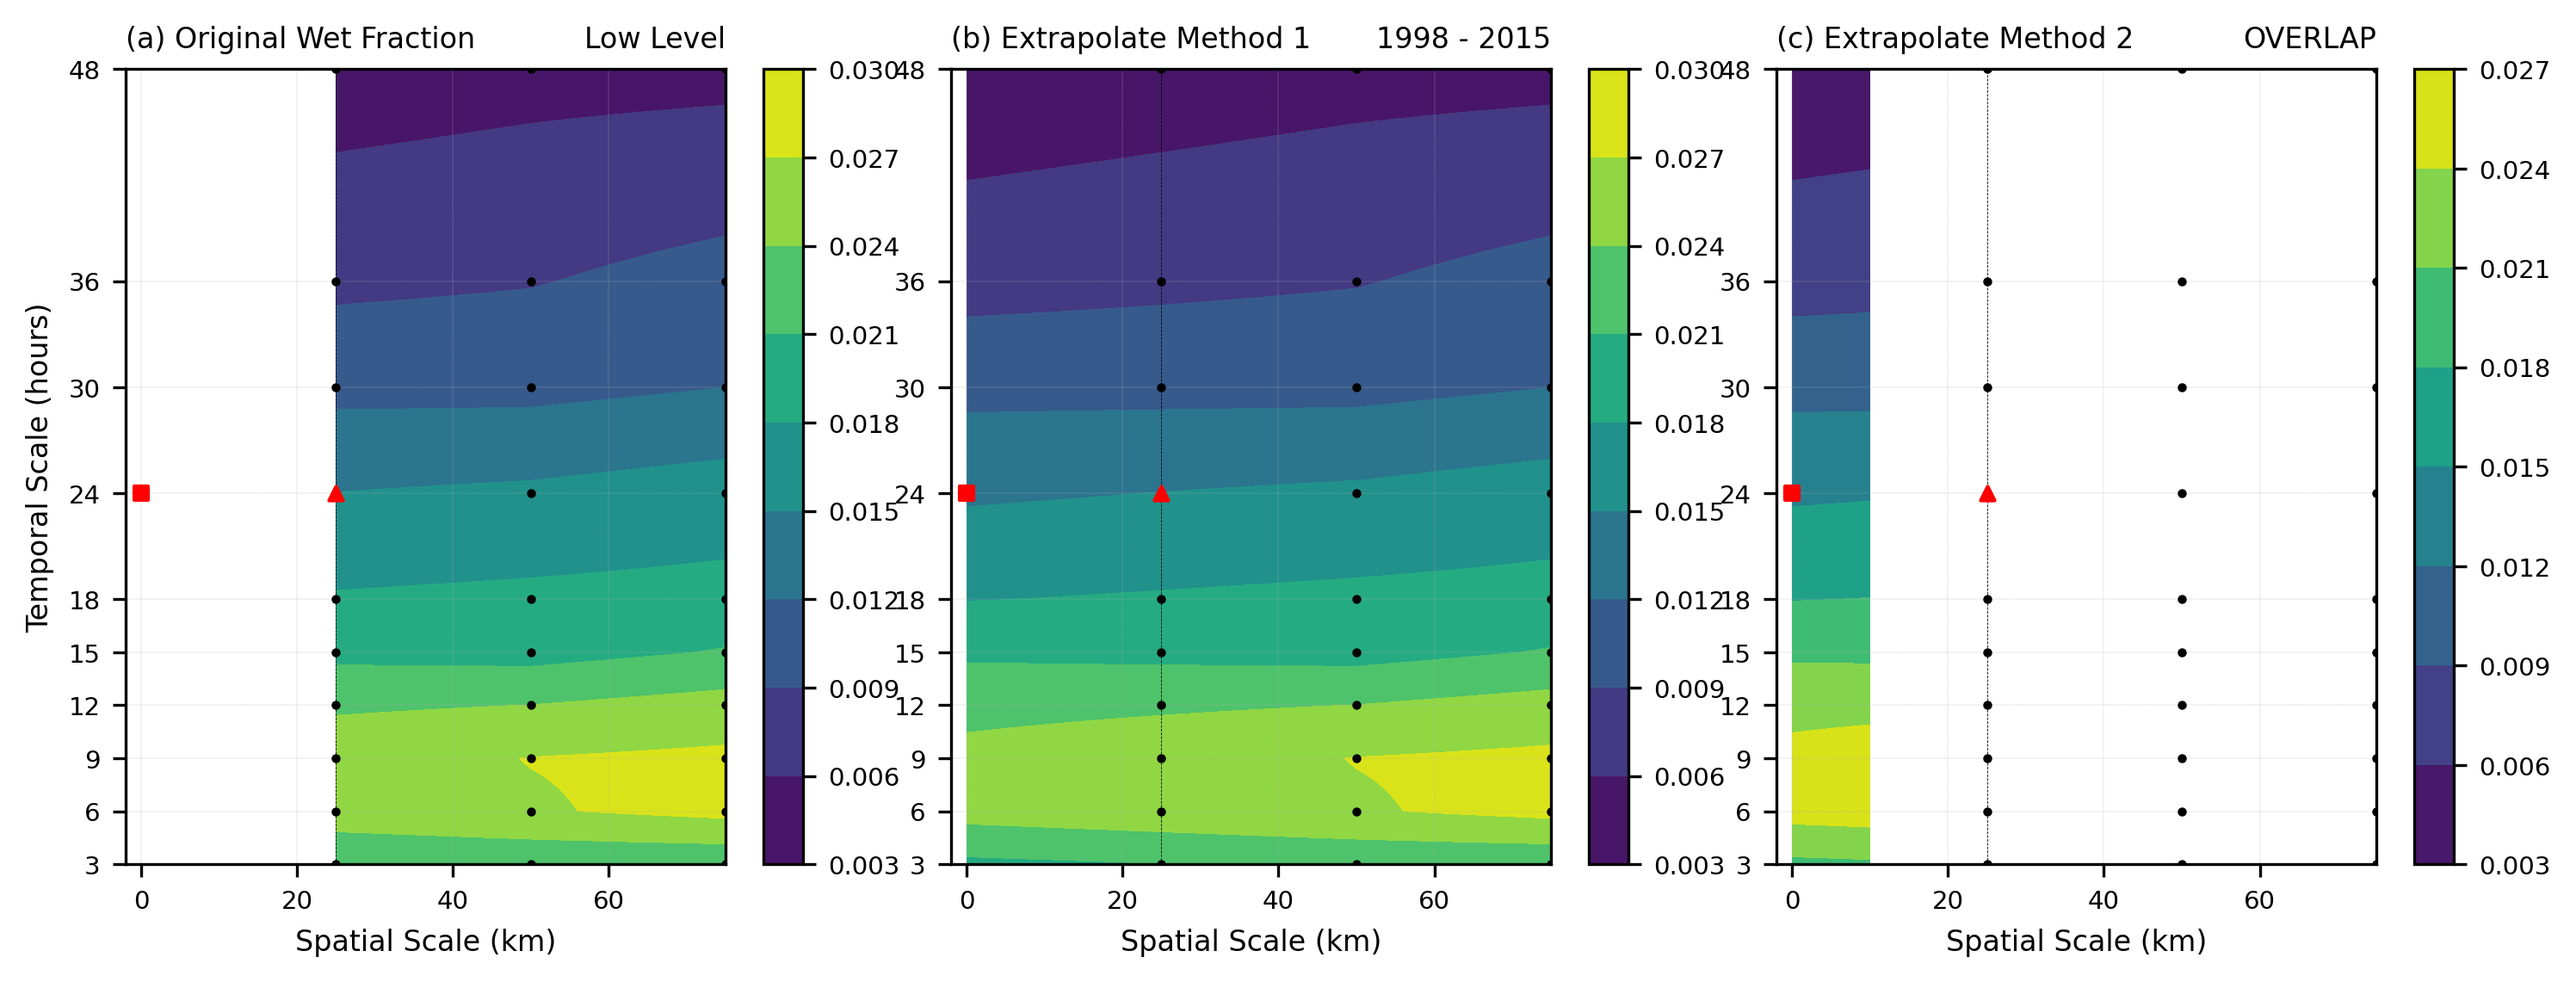

In [42]:
levels = np.arange(0,0.85,0.05)
levels = None
xxx1 = np.linspace(0, 30, 5)
xxx2 = np.linspace(30, 55, 5)

fig = plt.figure(figsize=(12,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================
ax1 = plt.subplot(gs[0, 0])
a1 = ax1.contourf(xscales_km, tscales_INTER, WET_MATRIX_INTER, cmap='viridis', levels=levels)

ax1.scatter(origin_x, origin_t, s=15, c='r', zorder=5, marker='^',label='origin')
ax1.scatter(target_x, target_t, s=15, marker='s', c='r', zorder=5, label ='target')

ax1.axvline(x=L1, color='k', linestyle='--', linewidth=0.2)

ax1.plot(xscales_km_2d, tscales_2d, '.k', markersize=3)

# ax1.scatter(xxx1, (xxx1 - X0[best_index]) / U[best_index], s=2)
# ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b', linewidth=0.5)
# ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b', linewidth=0.5)

ax1.set_title('(a) Original Wet Fraction', loc='left', fontsize=8)
ax1.set_title(f'{name}',loc='right',fontsize=8)
ax1.set_xlabel('Spatial Scale (km)', fontsize=8)
ax1.set_ylabel('Temporal Scale (hours)', fontsize=8)

ax1.set_yticks(tscales)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.1, linestyle='--')

cbar = plt.colorbar(a1)
cbar.ax.tick_params(labelsize=7)

ax1.set_xlim(-2,L1*npix)

# ============================================================
ax1 = plt.subplot(gs[0, 1])
a1 = ax1.contourf(new_spatial_scale, temporal_scale, new_wet_fraction, cmap='viridis', levels=levels)

ax1.scatter(origin_x, origin_t, s=15, c='r', zorder=5, marker='^',label='origin')
ax1.scatter(target_x, target_t, s=15, marker='s', c='r', zorder=5, label ='target')

ax1.axvline(x=L1, color='k', linestyle='--', linewidth=0.2)

ax1.plot(xscales_km_2d, tscales_2d, '.k', markersize=3)

# ax1.scatter(xxx1, (xxx1 - X0[best_index]) / U[best_index], s=2)
# ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b', linewidth=0.5)
# ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b', linewidth=0.5)

ax1.set_title('(b) Extrapolate Method 1', loc='left', fontsize=8)
ax1.set_title(f'{yy_s} - {yy_e}', loc='right', fontsize=8)
ax1.set_xlabel('Spatial Scale (km)', fontsize=8)
ax1.set_xlim(-2,L1*npix)

ax1.set_yticks(tscales)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.1, linestyle='--')

cbar = plt.colorbar(a1)
cbar.ax.tick_params(labelsize=7)

# ============================================================
ax1 = plt.subplot(gs[0, 2])
a1 = ax1.contourf(new_xscales, tscales_INTER, interpolated_wet_fraction, cmap='viridis', levels=levels)

ax1.scatter(origin_x, origin_t, s=15, c='r', zorder=5, marker='^',label='origin')
ax1.scatter(target_x, target_t, s=15, marker='s', c='r', zorder=5, label ='target')

ax1.axvline(x=L1, color='k', linestyle='--', linewidth=0.2)

ax1.plot(xscales_km_2d, tscales_2d, '.k', markersize=3)

# ax1.scatter(xxx1, (xxx1 - X0[best_index]) / U[best_index], s=2)
# ax1.plot(xxx1, (xxx1 - X0[best_index]) / U[best_index], 'b', linewidth=0.5)
# ax1.plot(xxx2, (xxx2 - X0[best_index]) / U[best_index], '--b', linewidth=0.5)

ax1.set_title('(c) Extrapolate Method 2', loc='left', fontsize=8)
ax1.set_title(f'{fig_val}', loc='right', fontsize=8)
ax1.set_xlabel('Spatial Scale (km)', fontsize=8)

ax1.set_yticks(tscales)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.1, linestyle='--')

cbar = plt.colorbar(a1)
cbar.ax.tick_params(labelsize=7)

ax1.set_xlim(-2,L1*npix)

# ================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)

image_dir = f'../fig/Veneto_TRMM_{name.replace(' ','_')}_{yy_s}_{yy_e}_WF_{fig_val}.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0, facecolor=None)

In [43]:
def obtain_points(WET_input, tscale, Scale_column):

    xscales_km = [10, 20, 30, 40, 50]
    
    points_ref = np.where((tscale>15)&(tscale<24))[0]
    WET_ref = np.round(WET_input[points_ref,Scale_column],2)
    DICT = pd.DataFrame({'points':points_ref, 'WET':WET_ref})

    dif = []
    for nn in range(len(WET_ref)-1):
        dif.append((WET_ref[nn+1]-WET_ref[nn])**2)

    positions = np.where(dif == np.max(dif))[0]

    extracted_df = DICT.iloc[positions]
    pos_clear = extracted_df['points'].values

    pp_tmp = tscales_INTER[pos_clear]

    pos_tmp = np.ones(len(pp_tmp)) * xscales_km[Scale_column]

    return pos_tmp, pp_tmp

In [44]:
test_10 = obtain_points(WET_MATRIX_INTER, tscales_INTER, 0)
test_20 = obtain_points(WET_MATRIX_INTER, tscales_INTER, 1)

In [45]:
import numpy as np

# Given known points (time, space) and corresponding wet fraction values
points = np.array([[21.05402701350675, 10],  # (time, space)
                   [19.455727863931966, 20]]) # (time, space)

wet_fractions = np.array([0.3548404183359204, 0.3548786268090165])

# Target point: (time = 24, space = 0.0001)
target_point = np.array([24, 0.0001])

# Fit a linear model: Wet Fraction = a * time + b * space + c
A = np.hstack([points, np.ones((points.shape[0], 1))])  # Add bias column for c
coefficients = np.linalg.lstsq(A, wet_fractions, rcond=None)[0]

a, b, c = coefficients

# Predict wet fraction for the target point (24, 0.0001)
target_wet_fraction = a * target_point[0] + b * target_point[1] + c

print(f"Predicted wet fraction at time = {target_point[0]} hours and space = {target_point[1]} km is: {target_wet_fraction}")


Predicted wet fraction at time = 24.0 hours and space = 0.0001 km is: 0.3758689001703521


In [46]:
pos_xmin = np.argmin(np.abs(origin_x - new_spatial_scale))
pos_tmin = np.argmin(np.abs(origin_t - tscales_INTER))
pwet_origin_new = new_wet_fraction[pos_tmin, pos_xmin]

print(f'Origin wet fraction in OLD matrix: {pwet_origin}')
print(f'Origin wet fraction in NEW matrix: {pwet_origin_new}')
print()

pos_xmin = np.argmin(np.abs(target_x - new_spatial_scale))
pos_tmin = np.argmin(np.abs(target_t - tscales_INTER))
pwet_target_new = new_wet_fraction[pos_tmin, pos_xmin]

print(f'Target wet fraction in OLD matrix : {pwet_target}')
print(f'Target wet fraction in NEW1 matrix: {pwet_target_new}')
print(f'Target wet fraction in NEW2 matrix: {wet_fraction_second}')
print()

beta_old = pwet_origin / pwet_target
beta_new1 = pwet_origin_new / pwet_target_new
beta_new2 = pwet_origin_new / pwet_target_new

print(f'Beta original (Zorzeto)   : {beta_old}')
print(f'Beta extrapolate all      : {beta_new1}')
print(f'Beta extrapolate only left: {beta_new2}')
print()

res = {} 
# res['beta'] = beta_old
res['beta'] = beta_new1
# res['beta'] = 1.09 #manual
print(f'Beta for downscalling: {res['beta']}')

Origin wet fraction in OLD matrix: 0.015040488075475198
Origin wet fraction in NEW matrix: 0.015040489336822897

Target wet fraction in OLD matrix : 0.014658581699327506
Target wet fraction in NEW1 matrix: 0.014567484581090523
Target wet fraction in NEW2 matrix: 0.014567501609284434

Beta original (Zorzeto)   : 1.0260534329979014
Beta extrapolate all      : 1.0324698991853654
Beta extrapolate only left: 1.0324698991853654

Beta for downscalling: 1.0324698991853654


## Continue with Downscaling Process

In [47]:
parnames = ['eps', 'alp'] if acf == 'mar' else ['d0', 'mu0']

In [48]:
rcorr = down.grid_corr(xdaily, plot=True, thresh=thresh)

gam_s = down.vrf(L1, L0, (rcorr['{}_s'.format(parnames[0])],
                        rcorr['{}_s'.format(parnames[1])]), acf=acf)

dcorr =  down.down_corr(rcorr['vdist'], rcorr['vcorr'], L1, acf=acf,
                    use_ave=True, toll=0.005, opt_method='genetic', #default:'genetic', 'lbfgsb'
                    plot=True)

differential_evolution step 1: f(x)= 0.0017729791982781106
differential_evolution step 2: f(x)= 0.0017729791982781106
differential_evolution step 3: f(x)= 0.0016758943724411923
differential_evolution step 4: f(x)= 0.0016758943724411923
differential_evolution step 5: f(x)= 0.0015687226989159044
differential_evolution step 6: f(x)= 0.0015687226989159044
Polishing solution with 'L-BFGS-B'
integration domain is zero


In [49]:
print('Downscaling pdf - global Weibull parameters')
par_acf = (dcorr['{}_d'.format(parnames[0])], dcorr['{}_d'.format(parnames[1])])

Nd, Cd, Wd, gam_d, fval_w = down.down_wei(Ns, Cs, Ws, L1, L0, res['beta'], par_acf, acf=acf)

print('Downscaling pdf - yearly Weibull parameters')
NCWy, YEARSy = down.fit_yearly_weibull(tsc, thresh=thresh, maxmiss=300)
IMERG_N, IMERG_C, IMERG_W = down.wei_fit(IMERG_pixel_1dy, 1)

NYd, CYd, WYd, _, _ = down.down_wei(NCWy[:,0], NCWy[:,1], NCWy[:,2], L1, L0, res['beta'], par_acf, acf=acf)

Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [50]:
print(f'OBS daily Weibull Parameters  : {OBS_N}, {OBS_C}, {OBS_W}')
print(f'IMERG daily Weibull Parameters: {IMERG_N}, {IMERG_C}, {IMERG_W}')

OBS daily Weibull Parameters  : 1306, 11.149512600648059, 0.9990375236766723
IMERG daily Weibull Parameters: 101, 4.827632720489499, 1.3416349953523257


In [51]:
res['NYs'] = NCWy[:,0] # yearly Weibull parameters
res['CYs'] = NCWy[:,1] # yearly Weibull parameters
res['WYs'] = NCWy[:,2] # yearly Weibull parameters
res['NYd'] = NYd # Nd, Cd, Wd (downscaled parameters)
res['CYd'] = CYd # Nd, Cd, Wd (downscaled parameters)
res['WYd'] = WYd # Nd, Cd, Wd (downscaled parameters)

In [52]:
Tr = np.array([10, 20, 50, 100]) # pass
Fi = 1-1/Tr
res['Tr'] = Tr
# x0 = 150.0
x0 = 9.0*np.mean(CYd)
res['mev_d'] = down.mev_quant(Fi, x0, NYd, CYd, WYd, thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability
res['mev_s'] = down.mev_quant(Fi, x0, NCWy[:,0], NCWy[:,1], NCWy[:,2],thresh=thresh)[0] # Computes the MEV quantile for given non exceedance probability

res['gam_d'] = gam_d # variance reduction function downscale
res['gam_s'] = gam_s # variance reduction factor
res['Nd'] = Nd # Nd, Cd, Wd (downscaled parameters)
res['Cd'] = Cd # Nd, Cd, Wd (downscaled parameters)
res['Wd'] = Wd # Nd, Cd, Wd (downscaled parameters)
res['Ns'] = Ns # global Weibull parameters
res['Cs'] = Cs # global Weibull parameters
res['Ws'] = Ws # global Weibull parameters
res['{}_s'.format(parnames[0])] = rcorr['{}_s'.format(parnames[0])]
res['{}_s'.format(parnames[1])] = rcorr['{}_s'.format(parnames[1])]
res['{}_d'.format(parnames[0])] = dcorr['{}_d'.format(parnames[0])]
res['{}_d'.format(parnames[1])] = dcorr['{}_d'.format(parnames[1])]
res['corr_down_success'] =        dcorr['success']
res['corr_down_funval'] =         dcorr['funval']
res['w_down_funval'] = fval_w[0] # function value at the end of numerical minimization
res['thresh'] = thresh # threshold used in the analysis
res['clat'] = clat
res['clon'] = clon

mevd_quant:: ERROR - fsolve does not work -  change x0
mevd_quant:: ERROR - fsolve does not work -  change x0
mevd_quant:: ERROR - fsolve does not work -  change x0
mevd_quant:: ERROR - fsolve does not work -  change x0
mevd_quant:: ERROR - fsolve does not work -  change x0
mevd_quant:: ERROR - fsolve does not work -  change x0
mevd_quant:: ERROR - fsolve does not work -  change x0
mevd_quant:: ERROR - fsolve does not work -  change x0


Export as: ../fig/Veneto_TRMM_Low_Level_1998_2015_weibull_OVERLAP_1mm.png


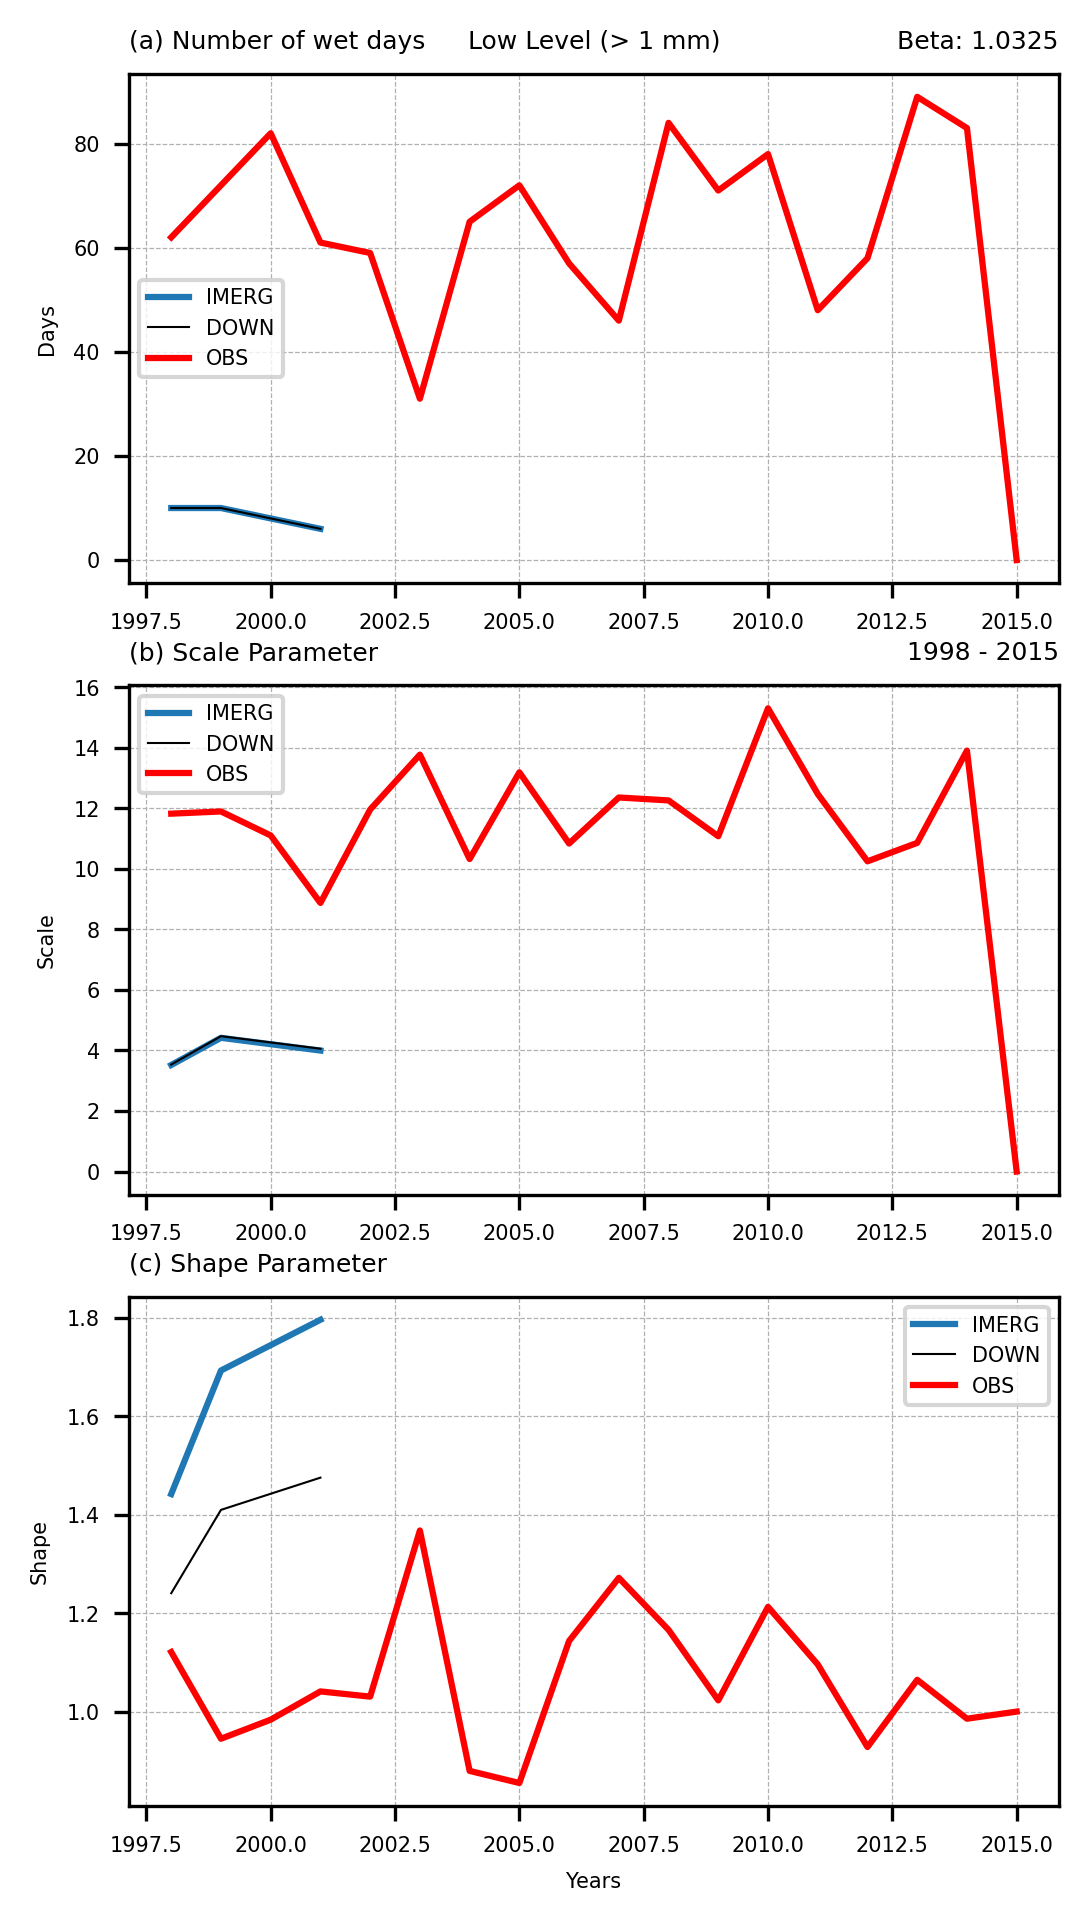

In [53]:
fig = plt.figure(figsize=(4,7.5),dpi=300)
gs = gridspec.GridSpec(3,1)

# =================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(YEARSy, res['NYs'], label=f'IMERG')
ax1.plot(YEARSy, res['NYd'], c='k', linewidth=0.5, label=f'DOWN')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,0], c='r', label=f'OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(a) Number of wet days',loc='left',fontsize=6)
ax1.set_title(f'Beta: {np.round(res['beta'],4)}',loc='right',fontsize=6)
ax1.set_title(f'{name} (> {thresh} mm)',loc='center',fontsize=6)
ax1.set_ylabel('Days', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(YEARSy, res['CYs'], label=f'IMERG')
ax1.plot(YEARSy, res['CYd'], c='k', linewidth=0.5, label=f'DOWN')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,1], c='r', label=f'OBS')
ax1.set_title(f'{yy_s} - {yy_e}',loc='right',fontsize=6)

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(b) Scale Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Scale', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

# =================================================================
ax1 = plt.subplot(gs[2, 0])
ax1.plot(YEARSy, res['WYs'], label=f'IMERG')
ax1.plot(YEARSy, res['WYd'], c='k', linewidth=0.5, label=f'DOWN')
ax1.plot(OBS_YEARS, OBS_NCW_1dy[:,2], c='r', label=f'OBS')

ax1.legend(fontsize=5)
ax1.grid(linestyle='--', linewidth=0.3)
ax1.set_title('(c) Shape Parameter',loc='left',fontsize=6)
ax1.set_ylabel('Shape', fontsize=5)
ax1.set_xlabel('Years', fontsize=5)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

#==================================================================================================
image_dir = f'../fig/Veneto_TRMM_{name.replace(' ','_')}_{yy_s}_{yy_e}_weibull_{fig_val}_{thresh}mm.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0, facecolor=None)